#Fragestellug
Welche grundlegende Modellarchitektur eignet sich am besten? <br>
**Parameter:**
* Textrepräsentation = POS-Embedding
* Problemdefinition = Klassifikation
* Reccurent-Layer = GRU


In [ ]:
%%capture
!pip install -U spacy
!python -m spacy download de_core_news_lg
!pip install xlsxwriter

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, SimpleRNN, GRU, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPooling1D, Conv1D,concatenate,Concatenate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import statistics
from statistics import mean, stdev
import spacy
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import xlsxwriter
from keras.initializers import Constant
from gensim.models import KeyedVectors
import random
import xlsxwriter
import sklearn as sk
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR

#Setup

In [ ]:
###############  Hyperparameter definieren   ######################
randomstate = 41
#Textaufbereitung
vocab_size = 10000
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

#Cross Validation
splits = 10
kfold = StratifiedKFold(n_splits=splits,shuffle=True, random_state=randomstate)

#Modell
embedding_dim = 300
batch_size = 20
no_epochs = 10
verbosity = 0

class_names = ['A1','A2','B1','B2','C']

##Funktionen

In [ ]:
def convert_to_one_hot(_fitdata,_transformdata):
  from sklearn.preprocessing import LabelEncoder
  from keras.utils import np_utils
  #Lable in Zahlen umwandeln
  encoder = LabelEncoder()
  encoder.fit(_fitdata)
  encoded_data = encoder.transform(_transformdata)
  #Zahlen in One Hot Vektoren umwandeln
  one_hot_vectors = np_utils.to_categorical(encoded_data)
  return [one_hot_vectors,encoder]

def convert_to_int(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {'A1': 1,'A2': 2,'B1': 3,'B2':4,'C':5}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return [label_sequence, label_tokenizer]

def convert_to_label(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {1: 'A1', 2: 'A2',3: 'B1',4:'B2',5:'C'}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return label_sequence

def model_evaluation_classification(_x_test, _y_test, _encoder):
  y_pred = model.predict(_x_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=['A1','A2','B1','B2','C'])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def model_evaluation_regression(_x_test, _y_test):
  y_pred = model.predict(_x_test)
  y_pred = np.clip(np.rint(y_pred), 0, 5)
  #y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

################# Funktion zum Trainieren und evaluieren #####################
def evaluate_model(_input=None, _target=None, _approach='klassisch', _architecture='GRU'):
  _approaches = ['klassisch', 'knn', 'hybrid']
  if _approach not in _approaches:
    raise ValueError("Invalid sim type. Expected one of: %s" % _approaches)
  _architectures = ['GRU', 'BiGRU', 'GRUP','CGRU','CGRUP']
  if _architecture not in _architectures:
    raise ValueError("Invalid sim type. Expected one of: %s" % _architectures)

  predicted_targets = np.array([])
  true_targets = np.array([])
  acc_per_fold = []
  kappa_per_fold = []
  for train, test in kfold.split(_input, _target):   
    x_train = _input[train]
    x_test = _input[test]
    y_train = _target[train]
    y_test = _target[test]


    if _approach == 'hybrid':
      #Feature aufteilen ling/text
      x_train_text = x_train[:,:120]
      x_train_ling = x_train[:,120:]
      x_test_text = x_test[:,:120]
      x_test_ling = x_test[:,120:]
      x_train = [x_train_text,x_train_ling]
      x_test = [x_test_text,x_test_ling]

    #Modelle zuweisen
    if _architecture == 'GRU':
      print('Model = GRU')
      model = GRU_model()
    elif _architecture == 'BiGRU':
      print('Model = BiGRU')
      model = BiGRU_model()
    elif _architecture == 'GRUP':
      print('Model = GRUP')
      model = GRUP_model()
    elif _architecture == 'CGRU':
      print('Model = CGRU')
      model = CGRU_model()
    elif _architecture == 'CGRUP':
      print('Model = CGRUP')
      model = CGRUP_model()

    if _approach == 'hybrid' or _approach == 'knn':
      #Zielvariablen in One Hot Repräsentation umwandeln
      one_hot = convert_to_one_hot(_target,y_train)
      encoder = one_hot[1]
      y_train = one_hot[0]
    
    #Modell trainieren
    if _approach == 'hybrid' or _approach == 'knn':
      model.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)
    elif _approach == 'klassisch':
      model.fit(x_train,y_train)


    #Vorhersagen treffen
    predicted_labels = model.predict(x_test)

    if _approach == 'hybrid' or _approach == 'knn':
      #One Hot wieder in Labels umwandeln
      predicted_labels = np.argmax(predicted_labels, axis=1)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    predicted_targets= np.append(predicted_targets, predicted_labels)
    true_targets = np.append(true_targets, y_test)

    #Metriken berechnen
    kappa = cohen_kappa_score(y_test,predicted_labels,weights='quadratic')  
    acc = accuracy_score(y_test,predicted_labels)*100
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
  acc = mean(acc_per_fold)
  kappa = mean(kappa_per_fold)
  return predicted_targets, true_targets, acc, kappa

#Daten aufbereiten

In [ ]:
labels = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/metadaten.xlsx', index_col=0)
texts = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/texts.xlsx',index_col=0)

In [ ]:
labels.sort_values(by=['id'],inplace=True)
texts.sort_values(by=['id'],inplace=True)

In [ ]:
labels.cerf_rating.replace(['A2','A2+'],'A2', inplace=True)
labels.cerf_rating.replace(['B1','B1+'],'B1', inplace=True)
labels.cerf_rating.replace(['B2','B2+'],'B2', inplace=True)
labels.cerf_rating.replace(['C1','C2'],'C', inplace=True)

In [ ]:
l_labels = labels['cerf_rating'].to_list()
l_texts = texts['text'].to_list()

In [ ]:
print(len(l_labels))
print(len(l_texts))

1033
1033


In [ ]:
################ Texte aufbereiten #########################
#Texte in Spacy Dokumente umwandeln
l_docs = []
nlp = spacy.load("de_core_news_lg")
for text in tqdm(nlp.pipe(l_texts)):
    l_docs.append(text)

#Texte in POS umwandeln
l_pos_texts = []
for doc in tqdm(l_docs):
  l_pos = []
  for token in doc:
    l_pos.append(token.tag_)
  pos_string = ' '.join(l_pos)
  l_pos_texts.append(pos_string)

#Vokabular mit Tokenizer erstellen
word_index = {}
i = 1
for doc in l_docs:
  for token in doc:
    if token.tag_ not in word_index:
      word_index[token.tag_] = i
      i += 1

#texte mit Index in Zahlensequenz umwandeln
text_seqs = []
for doc in l_docs:
  seq = []
  for token in doc:
    seq.append(word_index[token.tag_])
  text_seqs.append(seq)

#Zahlenequenzen auf gleiche Läng bringen
input = pad_sequences(text_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)

1033it [00:13, 75.46it/s]
100%|██████████| 1033/1033 [00:00<00:00, 16335.94it/s]


In [ ]:
################ Labels aufbereiten #########################
target = np.array(l_labels)

In [ ]:
len(input[0])

120

#Grundlegende Architekturen vergleichen

##GRU,Pooling

In [ ]:
#Architektur 2
def GRUP_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(GRU(embedding_dim,return_sequences=True))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model

  0%|          | 0/100 [00:00<?, ?it/s]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  1%|          | 1/100 [01:02<1:43:36, 62.80s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  2%|▏         | 2/100 [02:05<1:42:50, 62.97s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  3%|▎         | 3/100 [03:08<1:41:46, 62.95s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  4%|▍         | 4/100 [04:11<1:40:42, 62.95s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  5%|▌         | 5/100 [05:14<1:39:41, 62.97s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  6%|▌         | 6/100 [06:17<1:38:34, 62.92s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  7%|▋         | 7/100 [07:20<1:37:24, 62.85s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  8%|▊         | 8/100 [08:23<1:36:18, 62.81s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


  9%|▉         | 9/100 [09:25<1:35:09, 62.74s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 10%|█         | 10/100 [10:28<1:34:17, 62.86s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 11%|█         | 11/100 [11:31<1:33:12, 62.84s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 12%|█▏        | 12/100 [12:34<1:32:12, 62.87s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 13%|█▎        | 13/100 [13:37<1:31:01, 62.78s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 14%|█▍        | 14/100 [14:39<1:30:00, 62.79s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 15%|█▌        | 15/100 [15:42<1:28:58, 62.80s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 16%|█▌        | 16/100 [16:45<1:27:55, 62.80s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 17%|█▋        | 17/100 [17:48<1:27:04, 62.94s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 18%|█▊        | 18/100 [18:51<1:26:03, 62.97s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 19%|█▉        | 19/100 [19:54<1:25:01, 62.98s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 20%|██        | 20/100 [20:57<1:24:01, 63.02s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 21%|██        | 21/100 [22:01<1:23:05, 63.11s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 22%|██▏       | 22/100 [23:04<1:21:55, 63.02s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 23%|██▎       | 23/100 [24:07<1:20:53, 63.03s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 24%|██▍       | 24/100 [25:09<1:19:40, 62.91s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 25%|██▌       | 25/100 [26:13<1:18:50, 63.07s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 26%|██▌       | 26/100 [27:15<1:17:31, 62.85s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 27%|██▋       | 27/100 [28:18<1:16:33, 62.93s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 28%|██▊       | 28/100 [29:21<1:15:31, 62.94s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 29%|██▉       | 29/100 [30:24<1:14:30, 62.96s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 30%|███       | 30/100 [31:27<1:13:23, 62.91s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 31%|███       | 31/100 [32:30<1:12:26, 62.99s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 32%|███▏      | 32/100 [33:33<1:11:16, 62.89s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 33%|███▎      | 33/100 [34:36<1:10:17, 62.94s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 34%|███▍      | 34/100 [35:38<1:09:09, 62.87s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 35%|███▌      | 35/100 [36:41<1:08:07, 62.88s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 36%|███▌      | 36/100 [37:44<1:06:57, 62.77s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 37%|███▋      | 37/100 [38:47<1:05:55, 62.79s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 38%|███▊      | 38/100 [39:50<1:05:10, 63.07s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 39%|███▉      | 39/100 [40:54<1:04:10, 63.12s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 40%|████      | 40/100 [41:56<1:02:56, 62.95s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 41%|████      | 41/100 [42:59<1:01:44, 62.79s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 42%|████▏     | 42/100 [44:01<1:00:40, 62.77s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 43%|████▎     | 43/100 [45:04<59:39, 62.80s/it]  

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 44%|████▍     | 44/100 [46:07<58:42, 62.90s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 45%|████▌     | 45/100 [47:11<57:46, 63.02s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 46%|████▌     | 46/100 [48:13<56:35, 62.88s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 47%|████▋     | 47/100 [49:16<55:31, 62.86s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 48%|████▊     | 48/100 [50:19<54:31, 62.91s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 49%|████▉     | 49/100 [51:22<53:27, 62.90s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 50%|█████     | 50/100 [52:25<52:26, 62.94s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 51%|█████     | 51/100 [53:28<51:25, 62.97s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 52%|█████▏    | 52/100 [54:31<50:29, 63.12s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 53%|█████▎    | 53/100 [55:35<49:27, 63.15s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 54%|█████▍    | 54/100 [56:38<48:23, 63.13s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 55%|█████▌    | 55/100 [57:41<47:17, 63.07s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 56%|█████▌    | 56/100 [58:44<46:11, 62.99s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 57%|█████▋    | 57/100 [59:46<45:07, 62.96s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 58%|█████▊    | 58/100 [1:00:50<44:06, 63.00s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 59%|█████▉    | 59/100 [1:01:53<43:04, 63.04s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 60%|██████    | 60/100 [1:02:56<42:06, 63.16s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 61%|██████    | 61/100 [1:03:59<41:02, 63.13s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 62%|██████▏   | 62/100 [1:05:02<39:54, 63.02s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 63%|██████▎   | 63/100 [1:06:05<38:51, 63.02s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 64%|██████▍   | 64/100 [1:07:08<37:47, 63.00s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 65%|██████▌   | 65/100 [1:08:11<36:45, 63.00s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 66%|██████▌   | 66/100 [1:09:14<35:46, 63.13s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 67%|██████▋   | 67/100 [1:10:17<34:39, 63.02s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 68%|██████▊   | 68/100 [1:11:20<33:36, 63.03s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 69%|██████▉   | 69/100 [1:12:23<32:32, 63.00s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 70%|███████   | 70/100 [1:13:26<31:26, 62.88s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 71%|███████   | 71/100 [1:14:28<30:23, 62.87s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 72%|███████▏  | 72/100 [1:15:32<29:22, 62.95s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 73%|███████▎  | 73/100 [1:16:34<28:17, 62.88s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 74%|███████▍  | 74/100 [1:17:38<27:19, 63.07s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 75%|███████▌  | 75/100 [1:18:41<26:15, 63.03s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 76%|███████▌  | 76/100 [1:19:43<25:10, 62.94s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 77%|███████▋  | 77/100 [1:20:46<24:07, 62.93s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 78%|███████▊  | 78/100 [1:21:49<23:01, 62.82s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 79%|███████▉  | 79/100 [1:22:52<21:57, 62.74s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 80%|████████  | 80/100 [1:23:54<20:55, 62.79s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 81%|████████  | 81/100 [1:24:58<19:55, 62.92s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 82%|████████▏ | 82/100 [1:26:01<18:53, 62.97s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 83%|████████▎ | 83/100 [1:27:04<17:49, 62.92s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 84%|████████▍ | 84/100 [1:28:07<16:47, 62.94s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 85%|████████▌ | 85/100 [1:29:09<15:43, 62.87s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 86%|████████▌ | 86/100 [1:30:12<14:40, 62.91s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 87%|████████▋ | 87/100 [1:31:16<13:39, 63.05s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 88%|████████▊ | 88/100 [1:32:19<12:36, 63.02s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 89%|████████▉ | 89/100 [1:33:21<11:32, 62.96s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 90%|█████████ | 90/100 [1:34:24<10:29, 62.91s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 91%|█████████ | 91/100 [1:35:27<09:25, 62.86s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 92%|█████████▏| 92/100 [1:36:30<08:23, 62.88s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 93%|█████████▎| 93/100 [1:37:33<07:20, 62.97s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 94%|█████████▍| 94/100 [1:38:36<06:17, 62.91s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 95%|█████████▌| 95/100 [1:39:39<05:14, 62.88s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 96%|█████████▌| 96/100 [1:40:42<04:11, 62.95s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 97%|█████████▋| 97/100 [1:41:45<03:09, 63.01s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 98%|█████████▊| 98/100 [1:42:48<02:05, 62.95s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


 99%|█████████▉| 99/100 [1:43:51<01:02, 62.92s/it]

Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP
Model = GRUP


100%|██████████| 100/100 [1:44:53<00:00, 62.94s/it]


Confusion matrix, without normalization


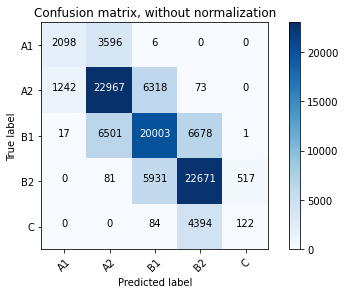

Normalized confusion matrix


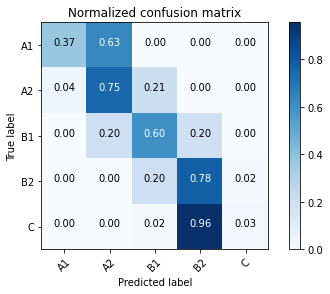

In [ ]:
##### GRUP
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input, target, 'knn', 'GRUP')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)

grup = {'name': 'GRU,Pooling',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)}

plot_confusion_matrix(all_predicted_targets, all_true_targets)

##CNN,GRU

In [ ]:
#Architektur 3
def CGRU_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(Conv1D(embedding_dim, 3, activation='relu'))
  model.add(GRU(embedding_dim))
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model


  0%|          | 0/100 [00:00<?, ?it/s]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  1%|          | 1/100 [01:19<2:11:36, 79.77s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  2%|▏         | 2/100 [02:25<1:56:20, 71.23s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  3%|▎         | 3/100 [03:30<1:51:12, 68.79s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  4%|▍         | 4/100 [04:36<1:48:14, 67.65s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  5%|▌         | 5/100 [05:42<1:45:56, 66.91s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  6%|▌         | 6/100 [06:48<1:44:10, 66.49s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  7%|▋         | 7/100 [07:53<1:42:36, 66.20s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  8%|▊         | 8/100 [08:59<1:41:27, 66.17s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


  9%|▉         | 9/100 [10:05<1:40:10, 66.05s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 10%|█         | 10/100 [11:11<1:38:57, 65.97s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 11%|█         | 11/100 [12:17<1:37:43, 65.88s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 12%|█▏        | 12/100 [13:22<1:36:33, 65.84s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 13%|█▎        | 13/100 [14:28<1:35:35, 65.92s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 14%|█▍        | 14/100 [15:34<1:34:20, 65.82s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 15%|█▌        | 15/100 [16:40<1:33:11, 65.79s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 16%|█▌        | 16/100 [17:45<1:32:00, 65.72s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 17%|█▋        | 17/100 [18:51<1:30:51, 65.68s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 18%|█▊        | 18/100 [19:57<1:29:46, 65.68s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 19%|█▉        | 19/100 [21:02<1:28:37, 65.65s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 20%|██        | 20/100 [22:08<1:27:26, 65.58s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 21%|██        | 21/100 [23:13<1:26:14, 65.51s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 22%|██▏       | 22/100 [24:19<1:25:19, 65.63s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 23%|██▎       | 23/100 [25:24<1:24:09, 65.58s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 24%|██▍       | 24/100 [26:30<1:22:59, 65.52s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 25%|██▌       | 25/100 [27:35<1:21:59, 65.60s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 26%|██▌       | 26/100 [28:41<1:20:54, 65.60s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 27%|██▋       | 27/100 [29:47<1:20:05, 65.82s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 28%|██▊       | 28/100 [30:53<1:19:00, 65.83s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 29%|██▉       | 29/100 [31:59<1:17:49, 65.76s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 30%|███       | 30/100 [33:05<1:16:49, 65.85s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 31%|███       | 31/100 [34:10<1:15:36, 65.75s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 32%|███▏      | 32/100 [35:16<1:14:36, 65.83s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 33%|███▎      | 33/100 [36:22<1:13:29, 65.82s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 34%|███▍      | 34/100 [37:28<1:12:21, 65.78s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 35%|███▌      | 35/100 [38:34<1:11:15, 65.78s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 36%|███▌      | 36/100 [39:39<1:10:07, 65.74s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 37%|███▋      | 37/100 [40:45<1:08:54, 65.62s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 38%|███▊      | 38/100 [41:51<1:07:56, 65.76s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 39%|███▉      | 39/100 [42:56<1:06:48, 65.71s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 40%|████      | 40/100 [44:02<1:05:46, 65.77s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 41%|████      | 41/100 [45:08<1:04:35, 65.69s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 42%|████▏     | 42/100 [46:13<1:03:29, 65.67s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 43%|████▎     | 43/100 [47:19<1:02:25, 65.72s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 44%|████▍     | 44/100 [48:25<1:01:15, 65.63s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 45%|████▌     | 45/100 [49:30<1:00:04, 65.53s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 46%|████▌     | 46/100 [50:35<58:57, 65.50s/it]  

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 47%|████▋     | 47/100 [51:41<57:58, 65.63s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 48%|████▊     | 48/100 [52:47<56:52, 65.62s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 49%|████▉     | 49/100 [53:52<55:45, 65.60s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 50%|█████     | 50/100 [54:58<54:40, 65.60s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 51%|█████     | 51/100 [56:03<53:30, 65.52s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 52%|█████▏    | 52/100 [57:09<52:27, 65.58s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 53%|█████▎    | 53/100 [58:14<51:17, 65.47s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 54%|█████▍    | 54/100 [59:20<50:10, 65.45s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 55%|█████▌    | 55/100 [1:00:25<49:02, 65.40s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 56%|█████▌    | 56/100 [1:01:30<47:56, 65.38s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 58%|█████▊    | 58/100 [1:03:42<45:50, 65.49s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 59%|█████▉    | 59/100 [1:04:47<44:43, 65.46s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 60%|██████    | 60/100 [1:05:53<43:40, 65.50s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 61%|██████    | 61/100 [1:06:58<42:35, 65.53s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 62%|██████▏   | 62/100 [1:08:04<41:35, 65.68s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 63%|██████▎   | 63/100 [1:09:10<40:28, 65.65s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 64%|██████▍   | 64/100 [1:10:15<39:23, 65.64s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 65%|██████▌   | 65/100 [1:11:21<38:14, 65.57s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 66%|██████▌   | 66/100 [1:12:27<37:14, 65.73s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 67%|██████▋   | 67/100 [1:13:32<36:07, 65.68s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 68%|██████▊   | 68/100 [1:14:38<34:59, 65.62s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 69%|██████▉   | 69/100 [1:15:44<33:54, 65.63s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 70%|███████   | 70/100 [1:16:49<32:51, 65.71s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 71%|███████   | 71/100 [1:17:55<31:46, 65.74s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 72%|███████▏  | 72/100 [1:19:01<30:36, 65.60s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 73%|███████▎  | 73/100 [1:20:06<29:30, 65.57s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 74%|███████▍  | 74/100 [1:21:12<28:24, 65.57s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 75%|███████▌  | 75/100 [1:22:17<27:20, 65.61s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 76%|███████▌  | 76/100 [1:23:23<26:17, 65.71s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 77%|███████▋  | 77/100 [1:24:29<25:11, 65.70s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 78%|███████▊  | 78/100 [1:25:34<24:04, 65.65s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 79%|███████▉  | 79/100 [1:26:40<22:56, 65.53s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 80%|████████  | 80/100 [1:27:45<21:50, 65.55s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 81%|████████  | 81/100 [1:28:51<20:47, 65.63s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 82%|████████▏ | 82/100 [1:29:57<19:40, 65.58s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 83%|████████▎ | 83/100 [1:31:02<18:35, 65.61s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 84%|████████▍ | 84/100 [1:32:08<17:28, 65.55s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 85%|████████▌ | 85/100 [1:33:14<16:24, 65.66s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 86%|████████▌ | 86/100 [1:34:19<15:19, 65.71s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 87%|████████▋ | 87/100 [1:35:25<14:13, 65.68s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 88%|████████▊ | 88/100 [1:36:32<13:11, 65.97s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 89%|████████▉ | 89/100 [1:37:37<12:04, 65.87s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 90%|█████████ | 90/100 [1:38:43<10:57, 65.76s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 91%|█████████ | 91/100 [1:39:49<09:53, 65.89s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 92%|█████████▏| 92/100 [1:40:55<08:47, 65.88s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 93%|█████████▎| 93/100 [1:42:01<07:40, 65.84s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 94%|█████████▍| 94/100 [1:43:06<06:35, 65.84s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 95%|█████████▌| 95/100 [1:44:12<05:29, 65.89s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 96%|█████████▌| 96/100 [1:45:19<04:23, 65.95s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 97%|█████████▋| 97/100 [1:46:24<03:17, 65.86s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 98%|█████████▊| 98/100 [1:47:30<02:11, 65.86s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


 99%|█████████▉| 99/100 [1:48:36<01:05, 65.84s/it]

Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU
Model = CGRU


100%|██████████| 100/100 [1:49:42<00:00, 65.82s/it]


Confusion matrix, without normalization


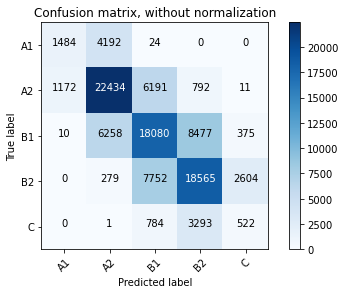

Normalized confusion matrix


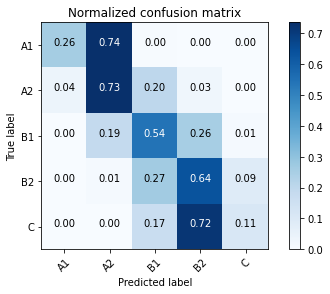

In [ ]:
##### CNN,GRU
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input, target, 'knn', 'CGRU')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)

cgru = {'name': 'CNN,GRU',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)}

plot_confusion_matrix(all_predicted_targets, all_true_targets)

##CNN,GRU,Pooling

In [ ]:
#Architektur 4
def CGRUP_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(Conv1D(embedding_dim, 3, activation='relu'))
  model.add(GRU(embedding_dim, return_sequences=True))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model

  0%|          | 0/100 [00:00<?, ?it/s]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  1%|          | 1/100 [01:06<1:50:13, 66.80s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  2%|▏         | 2/100 [02:13<1:49:23, 66.97s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  3%|▎         | 3/100 [03:20<1:47:49, 66.70s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  4%|▍         | 4/100 [04:26<1:46:30, 66.56s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  5%|▌         | 5/100 [05:32<1:45:11, 66.44s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  6%|▌         | 6/100 [06:39<1:44:08, 66.47s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  7%|▋         | 7/100 [07:46<1:43:15, 66.61s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  8%|▊         | 8/100 [08:53<1:42:11, 66.65s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


  9%|▉         | 9/100 [09:59<1:41:08, 66.69s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 10%|█         | 10/100 [11:06<1:40:00, 66.67s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 11%|█         | 11/100 [12:13<1:38:54, 66.69s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 12%|█▏        | 12/100 [13:20<1:38:08, 66.91s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 13%|█▎        | 13/100 [14:27<1:36:50, 66.78s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 14%|█▍        | 14/100 [15:33<1:35:44, 66.80s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 15%|█▌        | 15/100 [16:40<1:34:37, 66.79s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 16%|█▌        | 16/100 [17:47<1:33:43, 66.95s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 17%|█▋        | 17/100 [18:54<1:32:21, 66.77s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 18%|█▊        | 18/100 [20:01<1:31:15, 66.78s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 19%|█▉        | 19/100 [21:07<1:30:07, 66.76s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 20%|██        | 20/100 [22:14<1:29:01, 66.77s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 21%|██        | 21/100 [23:20<1:27:44, 66.63s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 22%|██▏       | 22/100 [24:27<1:26:44, 66.73s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 23%|██▎       | 23/100 [25:34<1:25:25, 66.57s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 24%|██▍       | 24/100 [26:40<1:24:15, 66.52s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 25%|██▌       | 25/100 [27:47<1:23:16, 66.62s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 26%|██▌       | 26/100 [28:53<1:22:06, 66.57s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 27%|██▋       | 27/100 [30:00<1:21:12, 66.75s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 28%|██▊       | 28/100 [31:07<1:20:05, 66.75s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 29%|██▉       | 29/100 [32:14<1:18:55, 66.69s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 30%|███       | 30/100 [33:20<1:17:42, 66.61s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 31%|███       | 31/100 [34:27<1:16:31, 66.54s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 32%|███▏      | 32/100 [35:33<1:15:29, 66.61s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 33%|███▎      | 33/100 [36:40<1:14:19, 66.56s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 34%|███▍      | 34/100 [37:47<1:13:19, 66.65s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 35%|███▌      | 35/100 [38:53<1:12:12, 66.66s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 36%|███▌      | 36/100 [40:00<1:11:08, 66.70s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 37%|███▋      | 37/100 [41:07<1:10:01, 66.70s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 38%|███▊      | 38/100 [42:14<1:09:03, 66.84s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 39%|███▉      | 39/100 [43:21<1:07:53, 66.78s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 40%|████      | 40/100 [44:27<1:06:45, 66.76s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 41%|████      | 41/100 [45:34<1:05:36, 66.71s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 42%|████▏     | 42/100 [46:41<1:04:26, 66.66s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 43%|████▎     | 43/100 [47:48<1:03:26, 66.78s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 44%|████▍     | 44/100 [48:54<1:02:19, 66.77s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 45%|████▌     | 45/100 [50:01<1:01:16, 66.84s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 46%|████▌     | 46/100 [51:08<1:00:05, 66.78s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 47%|████▋     | 47/100 [52:15<58:58, 66.76s/it]  

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 48%|████▊     | 48/100 [53:22<58:00, 66.94s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 49%|████▉     | 49/100 [54:29<56:50, 66.88s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 50%|█████     | 50/100 [55:35<55:39, 66.78s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 51%|█████     | 51/100 [56:42<54:28, 66.70s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 52%|█████▏    | 52/100 [57:48<53:19, 66.66s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 53%|█████▎    | 53/100 [58:55<52:10, 66.61s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 54%|█████▍    | 54/100 [1:00:02<51:06, 66.67s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 55%|█████▌    | 55/100 [1:01:08<50:00, 66.68s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 56%|█████▌    | 56/100 [1:02:15<48:53, 66.66s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 57%|█████▋    | 57/100 [1:03:22<47:48, 66.71s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 58%|█████▊    | 58/100 [1:04:29<46:43, 66.76s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 59%|█████▉    | 59/100 [1:05:36<45:39, 66.82s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 60%|██████    | 60/100 [1:06:42<44:29, 66.75s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 61%|██████    | 61/100 [1:07:49<43:18, 66.63s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 62%|██████▏   | 62/100 [1:08:55<42:11, 66.62s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 63%|██████▎   | 63/100 [1:10:01<41:01, 66.52s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 64%|██████▍   | 64/100 [1:11:08<39:57, 66.61s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 65%|██████▌   | 65/100 [1:12:15<38:50, 66.59s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 66%|██████▌   | 66/100 [1:13:21<37:41, 66.52s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 67%|██████▋   | 67/100 [1:14:28<36:32, 66.45s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 68%|██████▊   | 68/100 [1:15:34<35:27, 66.50s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 69%|██████▉   | 69/100 [1:16:41<34:24, 66.60s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 70%|███████   | 70/100 [1:17:47<33:17, 66.58s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 71%|███████   | 71/100 [1:18:54<32:13, 66.66s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 72%|███████▏  | 72/100 [1:20:01<31:05, 66.62s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 73%|███████▎  | 73/100 [1:21:08<30:00, 66.69s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 74%|███████▍  | 74/100 [1:22:14<28:53, 66.66s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 75%|███████▌  | 75/100 [1:23:21<27:48, 66.76s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 76%|███████▌  | 76/100 [1:24:28<26:39, 66.67s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 77%|███████▋  | 77/100 [1:25:34<25:30, 66.56s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 78%|███████▊  | 78/100 [1:26:41<24:24, 66.56s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 79%|███████▉  | 79/100 [1:27:47<23:18, 66.62s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 80%|████████  | 80/100 [1:28:54<22:15, 66.75s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 81%|████████  | 81/100 [1:30:01<21:07, 66.71s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 82%|████████▏ | 82/100 [1:31:08<20:00, 66.72s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 83%|████████▎ | 83/100 [1:32:14<18:53, 66.65s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 84%|████████▍ | 84/100 [1:33:21<17:45, 66.56s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 85%|████████▌ | 85/100 [1:34:28<16:41, 66.75s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 86%|████████▌ | 86/100 [1:35:35<15:35, 66.80s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 87%|████████▋ | 87/100 [1:36:41<14:26, 66.67s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 88%|████████▊ | 88/100 [1:37:48<13:19, 66.63s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 89%|████████▉ | 89/100 [1:38:54<12:12, 66.57s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 90%|█████████ | 90/100 [1:40:01<11:06, 66.65s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 91%|█████████ | 91/100 [1:41:07<09:59, 66.59s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 92%|█████████▏| 92/100 [1:42:14<08:53, 66.64s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 93%|█████████▎| 93/100 [1:43:21<07:47, 66.83s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 94%|█████████▍| 94/100 [1:44:28<06:40, 66.77s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 95%|█████████▌| 95/100 [1:45:35<05:33, 66.74s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 96%|█████████▌| 96/100 [1:46:41<04:26, 66.64s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 97%|█████████▋| 97/100 [1:47:48<03:19, 66.64s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 98%|█████████▊| 98/100 [1:48:54<02:13, 66.62s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


 99%|█████████▉| 99/100 [1:50:01<01:06, 66.55s/it]

Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP
Model = CGRUP


100%|██████████| 100/100 [1:51:07<00:00, 66.68s/it]


Confusion matrix, without normalization


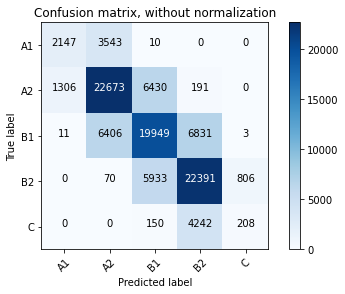

Normalized confusion matrix


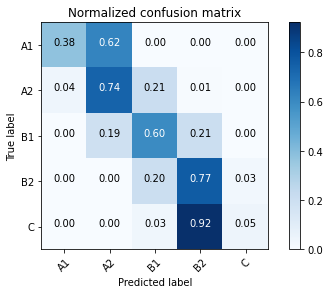

In [ ]:
##### CGRUP
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input, target, 'knn', 'CGRUP')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)

cgrup = {'name': 'CNN,GRU,Pooling',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)}

plot_confusion_matrix(all_predicted_targets, all_true_targets)

##Auswertung

In [ ]:
results = pd.DataFrame([grup, cgru,cgrup] ,columns=['name','acc','acc_std','qwk', 'qwk_std'])
results.sort_values('qwk')

,name,acc,acc_std,qwk,qwk_std
1,"CNN,GRU",59.118979,1.122073,0.740603,0.009698
2,"CNN,GRU,Pooling",65.211426,0.876939,0.797695,0.006155
0,"GRU,Pooling",65.685260,0.898315,0.801746,0.005875


In [ ]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/2_3_Architektur.xlsx', engine='xlsxwriter', index=False)  